<a href="https://colab.research.google.com/github/TejashreeGanesan/AI-Agents/blob/main/Multi_agent_Customer_Support_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Multi-agent Customer Support Automation
Six key elements makes agents to perfrom better:
- Role Playing
- Focus
- Tools
- Cooperation
- Guardrails
- Memory

---



In [1]:
pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of embedchain to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of embedchain to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of embedchain[github,youtube] to determine which version is compatible with other requirements. This could take a while.


In [1]:
pip install crewai langchain huggingface_hub

In [6]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [7]:
from crewai import Agent, Task, Crew

In [8]:
from langchain.llms import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id="mistralai/Mistral-7B-Instruct-v0.1",
    huggingfacehub_api_token="",
    task="text-generation",
)


## Role Playing, Focus and Cooperation
- Role Playing: Both agents have been given a role, goal and backstory.
- Focus: Both agents have been prompted to get into the character of the roles they are playing.
- Cooperation: Support Quality Assurance Agent can delegate work back to the Support Agent, allowing for these agents to work together.

In [9]:
support_agent = Agent(
  role="Senior Support Representative",
	goal="Be the most friendly and helpful "
        "support representative in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        " are now working on providing "
		"support to {customer}, a super important customer "
        " for your company."
		"You need to make sure that you provide the best support!"
		"Make sure to provide full complete answers, "
        " and make no assumptions."
	),
	allow_delegation=False,
	verbose=True,
    llm = llm
)

In [10]:
support_quality_assurance_agent = Agent(
	role="Support Quality Assurance Specialist",
	goal="Get recognition for providing the "
    "best support quality assurance in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        "are now working with your team "
		"on a request from {customer} ensuring that "
        "the support representative is "
		"providing the best support possible.\n"
		"You need to make sure that the support representative "
        "is providing full"
		"complete answers, and make no assumptions."
	),
	verbose=True,
  llm = llm
)

## Tools, Guardrails and Memory

In [11]:
from crewai_tools import SerperDevTool, \
                         ScrapeWebsiteTool, \
                         WebsiteSearchTool

### Possible Custom Tools
- Load customer data
- Tap into previous conversations
- Load data from a CRM
- Checking existing bug reports
- Checking existing feature requests
- Checking ongoing tickets and more

- Some ways of using CrewAI tools.

```Python
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()
```

- Instantiate a document scraper tool.
- The tool will scrape a page (only 1 URL) of the CrewAI documentation.

In [12]:
docs_scrape_tool = ScrapeWebsiteTool(
    website_url="https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/"
)

##### Different Ways to Give Agents Tools

- Agent Level: The Agent can use the Tool(s) on any Task it performs.
- Task Level: The Agent will only use the Tool(s) when performing that specific Task.

**Note**: Task Tools override the Agent Tools.
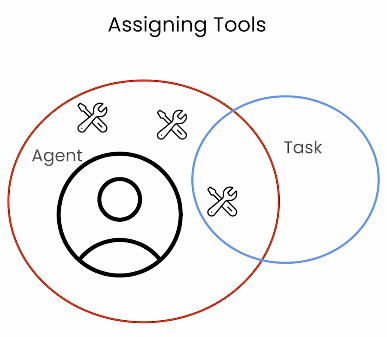

### Creating Tasks
- Passing the Tool on the Task Level.

In [13]:
inquiry_resolution = Task(
    description=(
        "{customer} just reached out with a super important ask:\n"
	    "{inquiry}\n\n"
        "{person} from {customer} is the one that reached out. "
		"Make sure to use everything you know "
        "to provide the best support possible."
		"You must strive to provide a complete "
        "and accurate response to the customer's inquiry."
    ),
    expected_output=(
	    "A detailed, informative response to the "
        "customer's inquiry that addresses "
        "all aspects of their question.\n"
        "The response should include references "
        "to everything you used to find the answer, "
        "including external data or solutions. "
        "Ensure the answer is complete, "
		"leaving no questions unanswered, and maintain a helpful and friendly "
		"tone throughout."
    ),
	tools=[docs_scrape_tool],
    agent=support_agent,
)

- `quality_assurance_review` is not using any Tool(s)
- Here the QA Agent will only review the work of the Support Agent

In [14]:
quality_assurance_review = Task(
    description=(
        "Review the response drafted by the Senior Support Representative for {customer}'s inquiry. "
        "Ensure that the answer is comprehensive, accurate, and adheres to the "
		"high-quality standards expected for customer support.\n"
        "Verify that all parts of the customer's inquiry "
        "have been addressed "
		"thoroughly, with a helpful and friendly tone.\n"
        "Check for references and sources used to "
        " find the information, "
		"ensuring the response is well-supported and "
        "leaves no questions unanswered."
    ),
    expected_output=(
        "A final, detailed, and informative response "
        "ready to be sent to the customer.\n"
        "This response should fully address the "
        "customer's inquiry, incorporating all "
		"relevant feedback and improvements.\n"
		"Don't be too formal, we are a chill and cool company "
	    "but maintain a professional and friendly tone throughout."
    ),
    agent=support_quality_assurance_agent,
)


### Creating the Crew

#### Memory
- Setting `memory=True` when putting the crew together enables Memory.

In [15]:
crew = Crew(
  agents=[support_agent, support_quality_assurance_agent],
  tasks=[inquiry_resolution, quality_assurance_review],
  verbose=2,
  memory=True,
  llm=llm
)

### Running the Crew

#### Guardrails
- By running the execution below, you can see that the agents and the responses are within the scope of what we expect from them.

In [16]:
# Inputs for the request
inputs = {
    "customer": "TM learning",
    "person": "Tejashree",
    "inquiry": "I need help with setting up a Crew "
               "and kicking it off, specifically "
               "how can I add memory to my crew? "
               "Can you provide guidance?"
}

# Construct the prompt
prompt = f"""
Customer: {inputs["customer"]}
Person: {inputs["person"]}
Inquiry: {inputs["inquiry"]}
Please provide a helpful and detailed response.
"""

# Generate a response from Hugging Face model
response = llm.invoke(prompt)

print("Response:", response)



Response: 
Customer: TM learning
Person: Tejashree
Inquiry: I need help with setting up a Crew and kicking it off, specifically how can I add memory to my crew? Can you provide guidance?
Please provide a helpful and detailed response.
---

Hello Tejashree,

I'm here to help you set up and kick off your crew in TM learning, and guide you through adding memory to it. Here's a step-by-step process:

**1. Setting up a Crew:**

   - Log in to your TM learning account.
   - Click on the 'Crew' tab in the top menu.
   - Click on the 'Create a new crew' button.
   - Enter your crew's name, description, and choose a crew type (e.g., Study, Project, or Social).
   - Click on 'Create crew' to finalize the setup.

**2. Adding Members to your Crew:**

   - After creating your crew, you'll be directed to the crew dashboard.
   - Click on the 'Members' tab.
   - Click on the 'Invite members' button.
   - You can invite members by entering their email addresses or by sharing a unique crew join link.
 

In [17]:
from IPython.display import Markdown
Markdown(response)


Customer: TM learning
Person: Tejashree
Inquiry: I need help with setting up a Crew and kicking it off, specifically how can I add memory to my crew? Can you provide guidance?
Please provide a helpful and detailed response.
---

Hello Tejashree,

I'm here to help you set up and kick off your crew in TM learning, and guide you through adding memory to it. Here's a step-by-step process:

**1. Setting up a Crew:**

   - Log in to your TM learning account.
   - Click on the 'Crew' tab in the top menu.
   - Click on the 'Create a new crew' button.
   - Enter your crew's name, description, and choose a crew type (e.g., Study, Project, or Social).
   - Click on 'Create crew' to finalize the setup.

**2. Adding Members to your Crew:**

   - After creating your crew, you'll be directed to the crew dashboard.
   - Click on the 'Members' tab.
   - Click on the 'Invite members' button.
   - You can invite members by entering their email addresses or by sharing a unique crew join link.
   - Once members accept the invitation, they'll be added to your crew.

**3. Adding Memory to your Crew:**

   - TM learning allows you to add memory (notes, ideas, or resources) to your crew, which can be accessed and collaborated on by all members.
   - To add memory, click on the 'Memory' tab in your crew dashboard.
   - Click on the 'Add memory' button.
   - You can add text, upload files (e.g., documents, images, or videos), or even create a poll.
   - Once you've added your memory, click on 'Post' to share it with your crew.

**4. Collaborating on Memory:**

   - Crew members can like, comment, or share the memory.
   - They can also edit the memory (if given permission) to add more information or make changes.
   - To give permission for editing, click on the three dots (⋮) next to the memory and select 'Allow editing'.

**5. Kicking off your Crew:**

   - To start collaborating effectively, you can set goals, create tasks, or schedule events for your crew.
   - Click on the 'Goals' or 'Tasks' tab to set objectives and assign responsibilities.
   - To schedule events, click on the 'Events' tab, then click on 'Create event' to set a date, time, and description.

By following these steps, you should be well on your way to setting up, kicking off, and collaborating effectively with your crew in TM learning. If you have any further questions or need additional assistance, please let me know!

Happy learning!